## Load data

In [18]:
import gzip
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [19]:
def load_images(file_path):
    with open(file_path, 'rb') as f:
        f.read(16)  # first 16 bytes contain header information
        buffer = f.read()
        data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        data = data.reshape(-1, 28, 28)
        return data

def load_labels(file_path):
    with open(file_path, 'rb') as f:
        f.read(8)  # first 8 bytes contain header information
        buffer = f.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)
        return labels
    
def load_fashion_mnist_dataset(images_path, labels_path):
    images = load_images(images_path)
    labels = load_labels(labels_path)
    data = []
    for image in images:
        hist = extract_color_histogram(image)
        data.append(hist)
    return np.array(images), np.array(data), labels



def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert grayscale image into an RGB image
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()




In [20]:
train_images_path = "data/minst_clothing/train-images-idx3-ubyte"
train_labels_path = "data/minst_clothing/train-labels-idx1-ubyte"
test_images_path = "data/minst_clothing/t10k-images-idx3-ubyte"
test_labels_path = "data/minst_clothing/t10k-labels-idx1-ubyte"


# Load dataset
train_images, train_data, train_labels = load_fashion_mnist_dataset(train_images_path, train_labels_path)
test_images, test_data, test_labels = load_fashion_mnist_dataset(test_images_path, test_labels_path)

print(f"Train images shape: {train_images.shape}")
print(f"Train data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train data shape: (60000, 512)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test data shape: (10000, 512)
Test labels shape: (10000,)


#### Extract Color histogram

## Examine the Histograms

In [21]:
def plot_images_and_histograms(images, bins=(8, 8, 8), color_space='LAB'):
    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Calculate colour histogram
        hist = extract_color_histogram(image, bins=bins)
        
        # Plot histogram 
        plt.subplot(5, 2, 2 * i + 2)
        colors = ('b', 'g', 'r')
        labels = ('Hue', 'Saturation', 'Value')
        for j, (col, label) in enumerate(zip(colors, labels)):
            hist_part = hist[j * bins[0] * bins[1]: (j + 1) * bins[0] * bins[1]]
            plt.plot(hist_part, color=col, label=label)
            plt.xlim([0, bins[0] * bins[1]])
        
        plt.title(f"Color Histogram {i+1}")
        plt.xlabel("Bins")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()



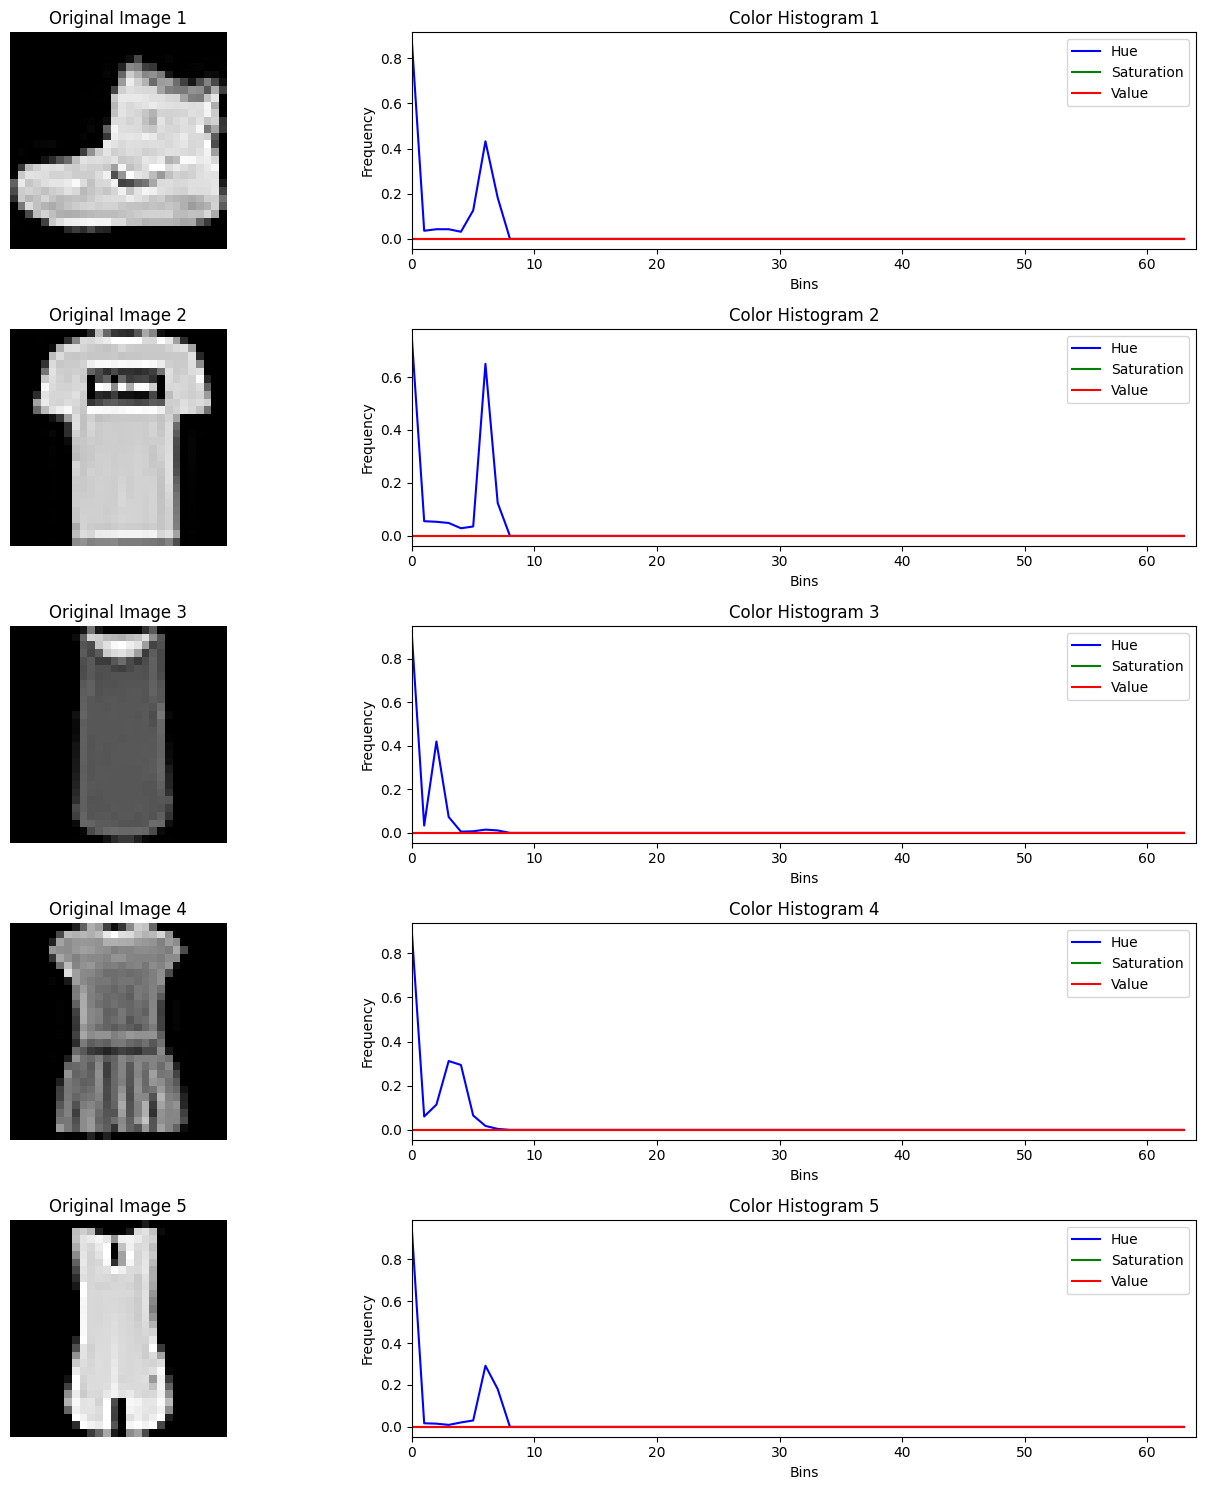

In [22]:
example_images = train_images[:5]

# Plot images and histograms
plot_images_and_histograms(example_images, bins=(8, 8, 8))

In [23]:
(trainX, testX, trainY, testY) = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# scale the features 
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
testX = scaler.transform(testX)

In [24]:

# Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))

Random Forest Accuracy: 0.4457333333333333
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.40      0.40      1486
           1       0.58      0.64      0.61      1546
           2       0.41      0.44      0.42      1499
           3       0.41      0.39      0.40      1484
           4       0.37      0.39      0.38      1515
           5       0.62      0.58      0.60      1493
           6       0.36      0.30      0.33      1505
           7       0.53      0.53      0.53      1476
           8       0.32      0.23      0.27      1500
           9       0.42      0.54      0.47      1496

    accuracy                           0.45     15000
   macro avg       0.44      0.45      0.44     15000
weighted avg       0.44      0.45      0.44     15000



### Optimized RF

In [26]:
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(42)
rf = RandomForestClassifier(n_estimators=1500, random_state=42, n_jobs=-1, min_samples_split = 3, min_samples_leaf = 1, max_depth = 35)
rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))


f1 = f1_score(testY, rf_predictions, average='weighted')  # 'weighted' takes into account the class imbalances
print("Random Forest F1 Score:", f1)

Random Forest Accuracy: 0.45753333333333335
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.40      0.41      1486
           1       0.59      0.65      0.62      1546
           2       0.42      0.45      0.44      1499
           3       0.41      0.41      0.41      1484
           4       0.39      0.40      0.39      1515
           5       0.63      0.59      0.60      1493
           6       0.39      0.33      0.36      1505
           7       0.54      0.55      0.54      1476
           8       0.35      0.25      0.29      1500
           9       0.42      0.55      0.48      1496

    accuracy                           0.46     15000
   macro avg       0.45      0.46      0.45     15000
weighted avg       0.45      0.46      0.45     15000

Random Forest F1 Score: 0.4535292739566447


In [30]:

np.random.seed(42)
# random forsest with: 'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000 
rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, min_samples_split = 2, min_samples_leaf = 1, max_features = 'log2', bootstrap=True, max_depth=None)

rf.fit(trainX, trainY)
rf_predictions = rf.predict(testX)
print("Random Forest Accuracy:", accuracy_score(testY, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(testY, rf_predictions))


f1 = f1_score(testY, rf_predictions, average='weighted')  # 'weighted' takes into account the class imbalances
print("Random Forest F1 Score:", f1)

Random Forest Accuracy: 0.45466666666666666
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.40      0.40      1486
           1       0.59      0.65      0.62      1546
           2       0.42      0.44      0.43      1499
           3       0.42      0.40      0.41      1484
           4       0.38      0.40      0.39      1515
           5       0.63      0.59      0.61      1493
           6       0.39      0.33      0.36      1505
           7       0.53      0.54      0.54      1476
           8       0.33      0.23      0.27      1500
           9       0.42      0.55      0.48      1496

    accuracy                           0.45     15000
   macro avg       0.45      0.45      0.45     15000
weighted avg       0.45      0.45      0.45     15000

Random Forest F1 Score: 0.4504665127148586


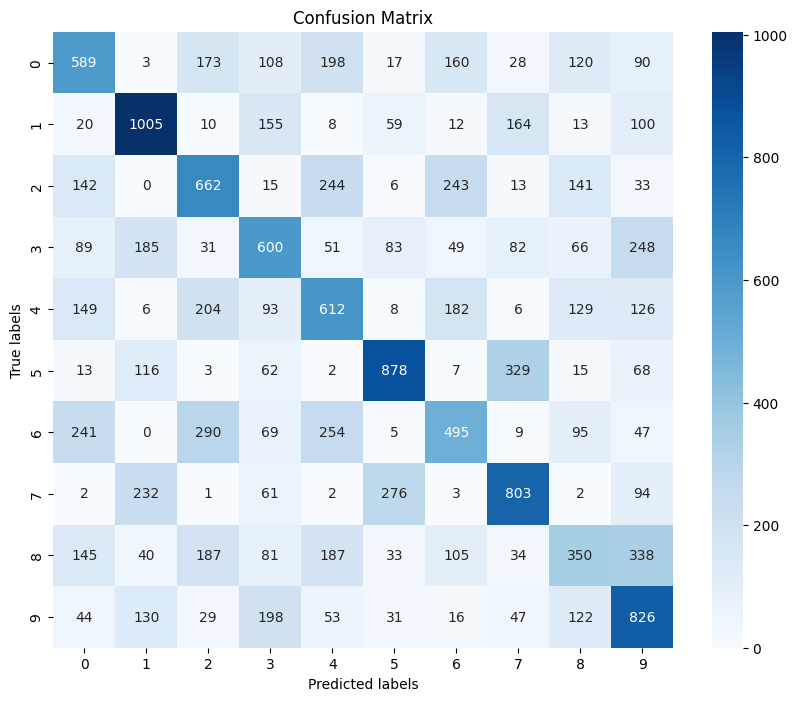

In [31]:

import seaborn as sns
import matplotlib.pyplot as plt

rf_cm = confusion_matrix(testY, rf_predictions)

fmt = 'd'

plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, cmap='Blues', fmt=fmt, xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()